In [24]:
import sys
import csv
import os
import re
import itertools
import datetime
from datetime import datetime
import keras

import time
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib
from scipy.io import savemat
import yfinance as yf
import talib
from ta import add_all_ta_features
from ta.utils import dropna


from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, SGDRegressor, BayesianRidge, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np

In [25]:
import os
from scipy.io import savemat


def check_outdir(outdir):

    if not os.path.exists(outdir):
        print(f'---create path {outdir}---')
        os.makedirs(outdir)

    return
                                                                               
def save_df(file, name, outdir, save_index=True, format='csv'):
    print(format)

    check_outdir(outdir)
    file_path = os.path.join(outdir, name)

    if format == 'csv':
        print(f'---save {name} to {outdir} in format .csv---')
        file_csv = file_path + '.csv'
        file.to_csv(file_csv, index=save_index)
        print(f'--- final result is saved as {name}.{format} ---')

    elif format == 'mat':
        print(f'---save {name} to {outdir} in format .mat---')
        file_mat = file_path + '.mat'
        savemat(file_mat, file)
        print(f'--- final result is saved as {name}.{format} ---')

    return

In [26]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [27]:
def list_files(path, format='.csv'):
    f'''return a list contain all filenames strings with format eg. [f1.csv, f2.csv, f3.csv]'''
    filenames = []
    for f in os.listdir(path):
        name, ext = os.path.splitext(f)
        if ext == format:
            filenames.append(f)
            
    return filenames

In [28]:
def rearrange_sequence_horizon(sequence_length, original, horizon):
        if len(original.shape)==1:
            new_data=np.zeros((sequence_length,horizon))
            for i in range(sequence_length):
                if i==0:
                    new_data[sequence_length-(i+1),:]=original[-(i*horizon+horizon):]
                else:
                    new_data[sequence_length-(i+1),:]=original[-(i*horizon+horizon):-i*horizon]
        else:
            new_data=np.zeros((sequence_length,horizon,original.shape[1]))
            for i in range(sequence_length):
                if i==0:
                    new_data[sequence_length-(i+1),:,:]=original[-(i*horizon+horizon):,:] #, (original.shape[1]*horizon,)
                else:
                    new_data[sequence_length-(i+1),:,:]=original[-(i*horizon+horizon):-i*horizon,:] #,(original.shape[1]*horizon,)
        return new_data

In [29]:
# def rearrange_sequence_horizon(sequence_length,original,horizon):
#     if len(original.shape)==1:
#         new_data=np.zeros((sequence_length,horizon))
#         for i in range(sequence_length):
#             if i==0:
#                 new_data[sequence_length-(i+1),:]=original[-(i*horizon+horizon):]
#             else:
#                 new_data[sequence_length-(i+1),:]=original[-(i*horizon+horizon):-i*horizon]
                 
     
#     else:
#         new_data=np.zeros((sequence_length,original.shape[1]*horizon))
#         for i in range(sequence_length):
#             if i==0:
#                 new_data[sequence_length-(i+1),:]=np.reshape(original[-(i*horizon+horizon):,:],(original.shape[1]*horizon,))
#             else:
#                 new_data[sequence_length-(i+1),:]=np.reshape(original[-(i*horizon+horizon):-i*horizon,:],(original.shape[1]*horizon,))

#     return new_data 

def csv_load_multi_features(file,
                            data_path,
                            train_num,
                            test_num,
                            horizon,
                            features_name=["Close"],
                            value_name=["Close"],
                            Date_format='%Y-%m-%d',
                            Norm_status=None):
                            #Date_format='%Y-%m-%d'):#
    '''
    window: train steps
    horizon: predict n steps
    download financial data, time-series with features , the to-be-predict value can be in the feature
    x_all:[n,feature_num]
    y_test:[n1,1]
    y_train:[n2,1]
    n=n1+n2+discard
    features are normalized one by one
    '%m/%d/%Y' '%Y-%m-%d'
    '''
    total_num = train_num + test_num
    fd = pd.read_csv(f'{data_path}/{file}', low_memory=False)
    fd['Date'] = pd.to_datetime(fd['Date'])
    fd_date=fd['Date']
    
    #Date_format='%Y-%m-%d'
    #Date_format='%m/%d/%Y'
    # str2date = lambda x: datetime.strptime(x.decode("utf-8"), Date_format)
    # # fd = np.genfromtxt(file_name+".csv", delimiter=',')
    # fd = np.genfromtxt(file_name, dtype=None,names=True, delimiter=',', converters = {0: str2date})
    # fd_date=fd['Date']
    
    fd_values=np.zeros((len(fd_date),len(features_name)))
    feature_num=len(features_name)
    for i in range(feature_num):
        fd_values[:,i]= fd[features_name[i]]
    
    
    if value_name[0] in features_name:
        fd_values[1:,features_name.index(value_name[0])]=fd_values[:-1,features_name.index(value_name[0])]
        fd_values[0,features_name.index(value_name[0])]=0
    
    if horizon==1:
        X_all=fd_values[-1*total_num:,:] #the features for feeding into the rc, !!!!without the close price
        # Y_train=fd_values[-1*(test_num+train_num):-1*test_num,-1] 
        # Y_test=fd_values[-1*test_num:,-1]
        Y_train=fd[value_name[0]][-1*total_num:-1*test_num] 
        Y_test=fd[value_name[0]][-1*test_num:]
    else:
        sequence_length=int(train_num/horizon)+int(test_num/horizon)
        X_all=rearrange_sequence_horizon(sequence_length, fd_values, horizon)
        Y_all=rearrange_sequence_horizon(sequence_length, fd[value_name[0]], horizon)
        # Y_train=Y_all[-1*(test_num+train_num):-1*test_num]
        # Y_test=Y_all[-1*test_num:]
        Y_train=Y_all[-1*(int(train_num/horizon)+int(test_num/horizon)):-1*int(test_num/horizon)] 
        Y_test=Y_all[-1*int(test_num/horizon):]
        
        
    date_train=fd_date[-1*total_num:-1*test_num]
    date_test=fd_date[-1*test_num:]
    
    
    "features normalization"
    X_all_norm=(X_all-X_all.mean(axis=0))/X_all.std(axis=0) #normalization 
    X_all_norm=X_all_norm-X_all_norm.min(axis=0) #move the values to positive
    
    # discard=5
    # train_num=5
    # test_num=3
    # total_num=discard+test_num+train_num
    # X_all=fd_values[-1*total_num:,:-1] #the features for feeding into the rc, !!!!without the close price
    # Y_train=fd_values[-1*(test_num+train_num):-1*test_num,-1] 
    # Y_test=fd_values[-1*test_num:,-1]
    # date_train=fd_date[-1*(test_num+train_num):-1*test_num]
    # date_test=fd_date[-1*test_num:]
    
    # if Norm_status is not None:
    #     X_all=X_all-np.mean(X_all)

    train_num = int(train_num/horizon)
    X_train=X_all_norm[:train_num,:]
    X_test=X_all_norm[train_num:,:]
    
    return X_train, X_test, Y_train, Y_test, date_train, date_test

def X_to_3d(raw):
    
    temp = np.zeros((len(raw), len(raw[0]), 1))
    for i in range(len(raw)):
        for j in range(len(raw[i])):
            temp[i][j] = raw[i][j]
    return temp


In [30]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
def prepare_data(filepath, file, n_in, n_out, n_vars, n_train, n_test):
    
    # read dataset
    total_num = n_train + n_test
    
    
    dataset = pd.read_csv(f'{filepath}/{file}', low_memory=False)
    feature_orders = ['Date'] + value_name + features_name_list
    dataset = dataset[feature_orders]
    
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset.sort_values(by='Date')
    dataset_dates=dataset['Date']
    
    # date format
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.set_index('Date', inplace=True)

    # dataset = dataset[-total_num:]
    # print('total dataset length =', len(dataset))
    
    # make sure data is float32
    values = dataset.values
    values = values.astype('float32')
    
    # scale the dataframe.
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = StandardScaler()
    scaled = scaler.fit_transform(values)
    
    #convert timeseries into supervised learning problem
    reframed = series_to_supervised(scaled, n_in, n_out)
    reframed = reframed[-total_num:]
    print('total reframed dataset length =', len(reframed))
    
    # take out the variables 取出保留的变量
    contain_vars = []
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1, n_vars+1)]  
    data = reframed [contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1, n_out)]]
    
    # modify features names
    col_names = ['Y'] + [f'X{i}' for i in range(1, n_vars )]
    contain_vars = []
    for i in range(n_vars):
        contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(1, n_in+1)]  
    data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1, n_out)]
    
    # split train and test
    values = data.values
    print('values length = ', len(values))
    
    train = values[:n_train, :]
    test = values[-n_test:, :]
    print('total train length =', len(train))
    print('total test length =', len(test))
    
    # split X and y.
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    
    # change X to LSTM input format, [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    return scaler, data, train_X, train_y, test_X, test_y, dataset
    

In [32]:
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='mae', optimizer='adam', repeats=1, if_plot=False):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    for i in range(repeats):
        
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)

        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=0, shuffle=False)
        model_list.append(model)
        
        if if_plot == True:
            p1 = pyplot.plot(history.history['loss'], color='blue', label='train')
            p2 = pyplot.plot(history.history['val_loss'], color='yellow',label='test')
        
    if if_plot == True:    
        pyplot.legend(["train","test"])
        pyplot.show()
        
    return model_list

In [33]:
def lstm_predict(model, data_prepare):
    scaler = data_prepare[0] 
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    
    # prediction
    yhat = model.predict(test_X)
    
    # scale back
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    
    # inverse transform
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

In [34]:
# Calculate RMSE
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

In [35]:
def get_y_avg(inv_y_list):
    result = []
    
    for i in range(len(inv_y_list[0])):
        value = 0
        for j in range(len(inv_y_list)):
            value += inv_y_list[j][i].mean()
        result.append(value/len(inv_y_list))
    return result
    

In [36]:

# reframed = prepare_data_test(data_path, 
#                                file, 
#                                n_in, 
#                                n_out, 
#                                n_vars, 
#                                n_train=500, 
#                                n_test=100)

filenames = [
             '^HSI.csv',
             '^NYA.csv', 
             '^N225.csv', 
             'MME=F.csv', 
             '^IXIC.csv', 
             'VTHR.csv', 
             'UKX.L.csv'
            ]


from datetime import date

# today = date.today().strftime('%Y-%m-%d')
today = '2023-12-19'
print("Today's date:", today)

n_in = 10
n_out = 10



train_num = 500 
test_num = 100 
total_num = train_num + test_num

# features_name_list = ['MACD', 'RSI', 'ATR', 'DXYNYB', 'VIX', 'EFFR', 'UMCSENT', '^IRX', '^TYX', '^TNX', 'Tspread', 'SOFR']
features_name_list = ['EFFR', 'VIX', 'DXYNYB', 'MACD', 'RSI', 'ATR', 'UMCSENT']
n_vars = len(features_name_list)
print(f'vars numbers = {n_vars}')


value_name=['Close']
Date_format='%Y-%m-%d'
if_plot_train_test_results=False


# rlt_path = f'./multivariate_rlt_experiment/{today}'
# data_path = f'./multivariate_data_experiment/{today}'

rlt_path = f'../multivariate_rlt_experiment/lstm_multistep'
data_path = f'../multivariate_data_experiment'

# filenames = list_files(data_path)


Today's date: 2023-12-19
vars numbers = 7


In [37]:
# pre_path = f'../multivariate_rlt_experiment/7features_add_close'
# pre_path = f'../multivariate_rlt_experiment/7features_no_close'

# pre_path = f'../multivariate_rlt_experiment/2024-01-17/add_close'
pre_path = f'../multivariate_rlt_experiment/2024-01-17/no_close'

In [38]:
def stock_index_experiment(data_path, 
                           n_in, 
                           n_out, 
                           n_vars, 
                           n_train, 
                           n_test):
    df_rlt = None
    real = None
    pred = None
    model = None
    
    inv_yhat = []
    inv_y = []
    inv_yhat_list = []
    inv_y_list = []
    inv_yhat_ave = []
    
    print('----------------------------------------------------')
    print(f'------{file} fit_lstm experiment is started------')
    data_prepare = prepare_data(data_path, 
                                   file, 
                                   n_in, 
                                   n_out, 
                                   n_vars, 
                                   n_train, 
                                   n_test)
    
    scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
    
    
    model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch, repeats=repeats)
    for i in range(len(model_list)):
        print(i)
        model = model_list[i]
        inv_yhat = lstm_predict(model, data_prepare)[0]
        inv_y = lstm_predict(model, data_prepare)[1]
        inv_yhat_list.append(inv_yhat)
        inv_y_list.append(inv_y)
    
    inv_yhat_ave = np.zeros(inv_y.shape)
    for i in range(repeats):
        inv_yhat_ave += inv_yhat_list[i]
        
    inv_yhat_ave = inv_yhat_ave/repeats
    
    pred = [x[0] for x in inv_y_list[0]]
    # pred = [np.mean(x) for x in inv_yhat_ave]
    real = dataset.Close.values[-(test_num):]
    
    rmse = calculate_rmse(real, pred)
    mape = calculate_mape(real, pred)
    print(f'{file} n_in{n_in} n_out{n_out} rmse == ', rmse)
    
    # df_rlt = pd.DataFrame({'real':real,
    #                        'lstm_multistep':pred})

    ### Compare with previous methods¶
    df_rlt = pd.read_csv(f'{pre_path}/{file}', low_memory=False)[-100:]
    df_rlt['real'] = real
    df_rlt['lstm_multistep'] = pred

    df_rlt_name = f'{file[:-4]}_multi_step_w{n_in}_h{n_out}'
    save_df(df_rlt, df_rlt_name, rlt_path, save_index=False, format='csv')
    
    print(f'------{file} fit_lstm experiment is done------')
    print('----------------------------------------------------')
    return df_rlt, inv_yhat_ave

In [22]:
n_neuron = 5
n_batch = 16
n_epoch = 200
repeats = 5
inv_yhat_list = []
inv_y_list = []

for n_in, n_out in [(4, 4), (10, 10)]:
    print('n_in=', n_in)
    print('n_out=', n_out)

    ### for each stock
    for file in filenames:
        df_rlt = None
        real = None
        pred = None
        model = None
        
        inv_yhat = []
        inv_y = []
        inv_yhat_list = []
        inv_y_list = []
        inv_yhat_ave = []
        
        print('----------------------------------------------------')
        print(f'------{file} fit_lstm experiment is started------')
        data_prepare = prepare_data(data_path, 
                                       file, 
                                       n_in, 
                                       n_out, 
                                       n_vars, 
                                       train_num, 
                                       test_num)
        
        scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
        
        
        model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch, repeats=repeats)
        for i in range(len(model_list)):
            print(i)
            model = model_list[i]
            inv_yhat = lstm_predict(model, data_prepare)[0]
            inv_y = lstm_predict(model, data_prepare)[1]
            inv_yhat_list.append(inv_yhat)
            inv_y_list.append(inv_y)
        
        inv_yhat_ave = np.zeros(inv_y.shape)
        for i in range(repeats):
            inv_yhat_ave += inv_yhat_list[i]
            
        inv_yhat_ave = inv_yhat_ave/repeats
        
        pred = [x[0] for x in inv_y_list[0]]
        # pred = [np.mean(x) for x in inv_yhat_ave]
        real = dataset.Close.values[-(test_num):]

        rmse = calculate_rmse(real, pred)
        mape = calculate_mape(real, pred)
        print(f'{file} n_in{n_in} n_out{n_out} rmse == ', rmse)
        
        # df_rlt = pd.DataFrame({'real':real,
        #                        'lstm_multistep':pred})
        
        ### Compare with previous methods¶
        df_rlt = pd.read_csv(f'{pre_path}/{file}', low_memory=False)[-100:]
        # df_rlt['real'] = real
        df_rlt['lstm_multistep'] = pred        
        df_rlt_name = f'{file[:-4]}_multi_step_w{n_in}_h{n_out}'
        save_df(df_rlt, df_rlt_name, rlt_path, save_index=False, format='csv')


        ### to find min rmse model
        models = [
                  # 'Lasso', 
                  # 'ElasticNet', 
                  # 'RandomForestRegressor',
                  # 'Linear regression', 'Ridge', 
                  # 'SGDRegressor', 'KNeighborsRegressor',
                  # 'BayesianRidge', 
                  'lstm_multistep']
        
        min_rmse = float('inf')
        min_rmse_model = None
        pred = None
        real = None
        
        for m in models:
            pred = df_rlt[m]
            real = df_rlt['Real']
            
            rmse = calculate_rmse(real, pred)
            if rmse < min_rmse:
                min_rmse = rmse
                min_rmse_model = m
        
        print(f'--- min rmse model is {min_rmse_model} ---')
        df_rlt_min_name = 'min_rmse_' + df_rlt_name 
        df_rlt_min_rmse = df_rlt[['Date', 'Real', min_rmse_model]]
        df_rlt_min_rmse = df_rlt_min_rmse.rename(columns={min_rmse_model: 'Regression'})
        save_df(df_rlt_min_rmse, df_rlt_min_name, rlt_path, save_index=False, format='csv')
        
        
        print(f'------{file} fit_lstm experiment is done------')
        print('----------------------------------------------------')

n_in= 4
n_out= 4
----------------------------------------------------
------^HSI.csv fit_lstm experiment is started------
total reframed dataset length = 600
values length =  600
total train length = 500
total test length = 100
0
4/4 [==============================] - 0s 819us/step
1
4/4 [==============================] - 0s 767us/step
2
4/4 [==============================] - 0s 711us/step
3
4/4 [==============================] - 0s 702us/step
4
4/4 [==============================] - 0s 790us/step
^HSI.csv n_in4 n_out4 rmse ==  451.77799719987377
csv
---save ^HSI_multi_step_w4_h4 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as ^HSI_multi_step_w4_h4.csv ---
--- min rmse model is lstm_multistep ---
csv
---save min_rmse_^HSI_multi_step_w4_h4 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as min_rmse_^HSI_multi_step_w4_h4.csv ---
------^HSI.csv fit_lstm experiment is done------
-------------------

In [23]:
#### w1 h1 regression models comparison

for file in filenames:
    df_rlt = pd.read_csv(f'{pre_path}/{file}', low_memory=False)[-100:]
    ### to find min rmse model
    models = ['Lasso'
              , 'ElasticNet'
              , 'RandomForestRegressor'
              ,'Linear regression'
              , 'Ridge'
              , 'SGDRegressor'
              , 'KNeighborsRegressor'
              ,'BayesianRidge']
    
    min_rmse = float('inf')
    min_rmse_model = None
    for m in models:
        pred = df_rlt[m]
        real = df_rlt['Real']
        
        rmse = calculate_rmse(real, pred)
        # print(f'{file} {m} rmse == {rmse}')
        if rmse < min_rmse:
            min_rmse = rmse
            min_rmse_model = m
            print(min_rmse_model)
    
    print(f'--- w1h1 min rmse model is {min_rmse_model} ---')
    df_rlt_min_name = 'min_rmse_' + f'{file[:-4]}_multi_step_w1_h1' 
    df_rlt_min_rmse = df_rlt[['Date', 'Real', min_rmse_model]]
    df_rlt_min_rmse = df_rlt_min_rmse.rename(columns={min_rmse_model: 'Regression'})
    save_df(df_rlt_min_rmse, df_rlt_min_name, rlt_path, save_index=False, format='csv')
        

Lasso
--- w1h1 min rmse model is Lasso ---
csv
---save min_rmse_^HSI_multi_step_w1_h1 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as min_rmse_^HSI_multi_step_w1_h1.csv ---
Lasso
ElasticNet
--- w1h1 min rmse model is ElasticNet ---
csv
---save min_rmse_^NYA_multi_step_w1_h1 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as min_rmse_^NYA_multi_step_w1_h1.csv ---
Lasso
--- w1h1 min rmse model is Lasso ---
csv
---save min_rmse_^N225_multi_step_w1_h1 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as min_rmse_^N225_multi_step_w1_h1.csv ---
Lasso
RandomForestRegressor
--- w1h1 min rmse model is RandomForestRegressor ---
csv
---save min_rmse_MME=F_multi_step_w1_h1 to ../multivariate_rlt_experiment/lstm_multistep in format .csv---
--- final result is saved as min_rmse_MME=F_multi_step_w1_h1.csv ---
Lasso
Ridge
--- w1h1 min rmse model is Ridge ---
csv
---sa

In [ ]:
# ### to find min rmse model
# models = ['Lasso', 'ElasticNet', 
#           'RandomForestRegressor',
#           'Linear regression', 'Ridge', 
#           'SGDRegressor', 'KNeighborsRegressor',
#           'BayesianRidge', 'lstm_multistep']

# min_rmse = float('inf')
# min_rmse_model = None

# for m in models:
#     pred = df_rlt[m]
#     real = df_rlt['Real']
    
#     rmse = calculate_rmse(real, pred)
#     if rmse < min_rmse:
#         min_rmse = rmse
#         min_rmse_model = m

# print(f'--- min rmse model is {m} ---')
# df_rlt_min_name = df_rlt_name + '_min_rmse'
# df_rlt_min_rmse = df_rlt[['Date', 'Real', min_rmse_model]]
# df_rlt_min_rmse = df_rlt_min_rmse.rename(columns={min_rmse_model: 'Regression'})
# save_df(df_rlt_min_rmse, df_rlt_min_name, rlt_path, save_index=False, format='csv')

In [ ]:
float('inf')

In [ ]:
df_rlt

In [ ]:
save_df(df_rlt, df_rlt_name, rlt_path, save_index=False, format='csv')

In [ ]:
n_neuron = 5
n_batch = 16
n_epoch = 200
repeats = 5
inv_yhat_list = []
inv_y_list = []

for n_in, n_out in [(20, 20)]:
    print('n_in=', n_in)
    print('n_out=', n_out)

    for file in filenames:
        df_rlt, inv_yhat_ave = stock_index_experiment(data_path, 
                               n_in, 
                               n_out, 
                               n_vars, 
                               n_train=train_num, 
                               n_test=test_num)    

In [ ]:
df_rlt

In [ ]:
inv_yhat_ave

In [ ]:
df_rlt

In [39]:
import os
os.path.abspath(os.getcwd())

'/Users/audreyw/Library/CloudStorage/GoogleDrive-wfaugust@gmail.com/Shared drives/Spatial optics-economic/experiment and analytical results/multivariate_python_fw'

In [40]:
fig_path = '../final results'

In [58]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 28 10:33:47 2024

@author: ting
"""
import numpy as np
from scipy.io import loadmat
from plot_sequence import *
import matplotlib.pyplot as plt
from datetime import datetime


csfont = {'fontname':'Times New Roman'}

def plot_stock_train_test(Y_train,Y_test,Y_pred_test,date_train,date_test,fang_file_name,title,target="Stock Price"):
    # fang_file_name=sio.loadmat("rlt-30-year-treasury-bond-rate-yield-chart")
    
    str2date = lambda x: datetime.strptime(x.decode("utf-8"), '%m/%d/%Y')
    # fd = np.genfromtxt(file_name+".csv", delimiter=',')
    fd = np.genfromtxt(fang_file_name, dtype=None,names=True, delimiter=',', converters = {0: str2date})
    fd_date=fd['Date']
    Lasso=fd["Lasso"]
    ElasticNet=fd["ElasticNet"]
    RandomForestRegressor=fd["RandomForestRegressor"]
    KNeighborsRegressor=fd["KNeighborsRegressor"]
    BayesianRidge=fd["BayesianRidge"]
    Real=fd["Real"]
    Ridge=fd["Ridge"]
    linear_regression=fd["Linear_regression"]
    SGDRegressor=fd["SGDRegressor"]
    
    
    fig,ax=plt.subplots()
    ax.plot(np.concatenate((date_train,date_test)), np.concatenate((Y_train,Y_test)),label="True")
    
    ax.plot(date_test,Y_pred_test,label="RC Prediction")
    # ax.plot(fd_date,BayesianRidge,label="BayesianRidge")
    ax.plot(fd_date,Lasso,label="Lasso")
    # ax.plot(fd_date,ElasticNet,label="ElasticNet")
    # ax.plot(fd_date,RandomForestRegressor,label="RandomForestRegressor")
    # ax.plot(fd_date,KNeighborsRegressor,label="KNeighborsRegressor")
    # ax.plot(fd_date,Ridge,label="Ridge")
    # ax.plot(fd_date,linear_regression,label="Linear")
    # ax.plot(fd_date,SGDRegressor,label="SGDRegressor")
    
    # formatter = mtick.FormatStrFormatter('%% %1.1f')
    # ax.yaxis.set_major_formatter(formatter)
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    plt.ylabel(target,fontsize=18,**csfont)
    plt.xlabel("Date",fontsize=18,**csfont)
    plt.title(title,fontsize=18,**csfont)
    plt.xticks(rotation=45)
    plt.legend(loc='upper center',bbox_to_anchor=(1.25, 1),prop={'family':'Times New Roman','size':12})
    # plt.title("Testing")
    plt.show()
    return 

def load_rc(stock_name,step):
    file_name = None
    if step==1:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+stock_name+"_RC_multi_step_w1_h1.csv"
    elif step==4:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+stock_name+"_RC_multi_step_w4_h4.csv"
    elif step==10:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+stock_name+"_RC_multi_step_w10_h10.csv"
    
    # fd = pd.read_csv(file_name, low_memory=False)
    str2date = lambda x: datetime.strptime(x.decode("utf-8"), '%Y-%m-%d')
    fd = np.genfromtxt(file_name, dtype=None,names=True, delimiter=',', converters = {0: str2date})
    fd_date=fd['Date']
    RC_predict=fd['RC_predict']
    fd_true=fd['True']

    return fd_date, RC_predict, fd_true


def load_reg(stock_name,step):
    file_name = None
    if step==1:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+'min_rmse_'+stock_name+"_multi_step_w1_h1.csv"
    elif step==4:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+'min_rmse_'+stock_name+"_multi_step_w4_h4.csv"
    elif step==10:
        file_name="../multivariate_rlt_experiment/lstm_multistep/"+'min_rmse_'+stock_name+"_multi_step_w10_h10.csv"
    
    # fd = pd.read_csv(file_name, low_memory=False)
    str2date = lambda x: datetime.strptime(x.decode("utf-8"), '%Y-%m-%d')
    fd = np.genfromtxt(file_name, dtype=None,names=True, delimiter=',', converters = {0: str2date})
    fd_date=fd['Date']
    reg=fd['Regression']

    return fd_date, reg
    
def RMSE(Y_true,Y_pred):
    
    error=np.sqrt(np.mean((Y_true-Y_pred)**2))
    
    return error


In [61]:
# =============================================================================
names=["^NYA", "^N225","^HSI","MME=F","^IXIC","VTHR","UKX.L"]
steps=[1, 4, 10]

date,rc_predict,true=load_rc("^NYA",1)
date,reg=load_reg("^NYA",1)

# plt.scatter(date,rc_predict)
# plt.scatter(date,true)
# plt.scatter(date,reg)
rc_01=[]
reg_01=[]

rc_04=[]
reg_04=[]


rc_10=[]
reg_10=[]

rc_20=[]
reg_20=[]


for i in range(len(steps)):
    step=steps[i]
    for j in range(len(names)):
        date,rc_predict,true=load_rc(names[j],step)
        date,reg=load_reg(names[j],step)
    
        "calculate N-RMSE"
        rc_error=RMSE(true,rc_predict)/np.mean(true)
        reg_error=RMSE(true,reg)/np.mean(true)
        # rc_error=RMSE(true,rc_predict)
        # reg_error=RMSE(true,reg)
        
        if step==1:
            rc_01.append(rc_error)
            reg_01.append(reg_error)
            
        elif step==4:
            rc_04.append(rc_error)
            reg_04.append(reg_error)
            
        elif step==10:
            rc_10.append(rc_error)
            reg_10.append(reg_error)

        elif step==20:
            rc_20.append(rc_error)
            reg_20.append(reg_error)


# rc_01=[38.4,394,152,3.2,108,0.57,25]
# reg_01=[97,333,255,8.5,106.9,1.23,50]

# rc_04=[30.5,518,140,3.96,119,2.39,20.8]
# reg_04=[184,599,451,16.4,237,2.5,101.8]

# rc_10=[61,680,255,8.01,265,3.42,43.6]
# reg_10=[311,943,696,26,409,4.4,172.9]

the_max=[17353,33753,29468,1391,16057,217,8012]


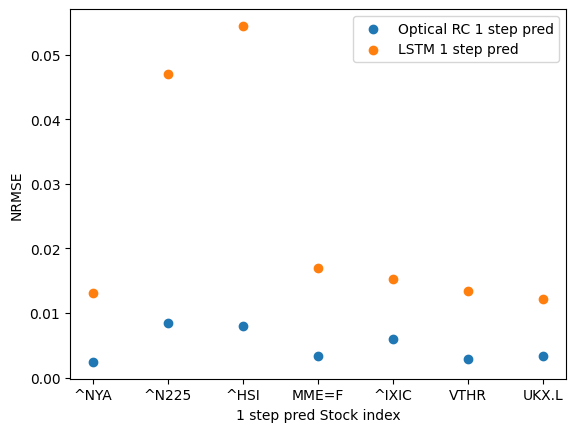

In [62]:
# plt.scatter(names,np.array(rc_01)/np.array(the_max),label="Optical RC 1 step pred scaled")
# plt.scatter(names,np.array(reg_01)/np.array(the_max),label="LSTM 1 step pred scaled")
# plt.scatter(names,np.abs(np.array(train_std)-np.array(test_std))/np.array(the_max),label="train - test")
plt.scatter(names,np.array(rc_01),label='Optical RC 1 step pred')
plt.scatter(names,np.array(reg_01),label='LSTM 1 step pred')

# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("1 step pred Stock index")
plt.ylabel("NRMSE")
plt.savefig(f'{fig_path}/NRMSE_fig_1.png', dpi=600, bbox_inches='tight')
# =============================================================================


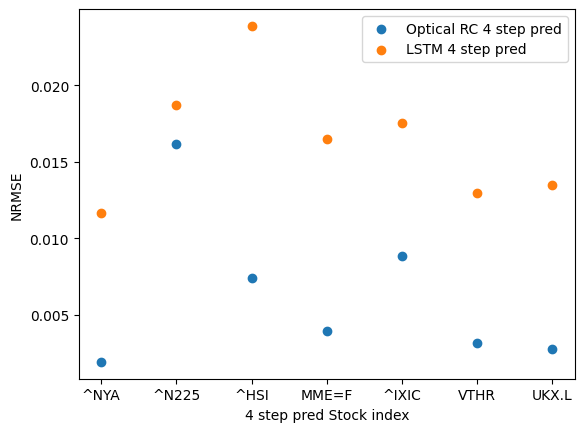

In [63]:
# plt.scatter(names,np.array(rc_04)/np.array(the_max),label="rc 04 scaled")
# plt.scatter(names,np.array(reg_04)/np.array(the_max),label="reg 04 scaled")
plt.scatter(names,np.array(rc_04),label='Optical RC 4 step pred')
plt.scatter(names,np.array(reg_04),label='LSTM 4 step pred')

# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("4 step pred Stock index")
plt.ylabel("NRMSE")
plt.savefig(f'{fig_path}/NRMSE_fig_4.png', dpi=600, bbox_inches='tight')

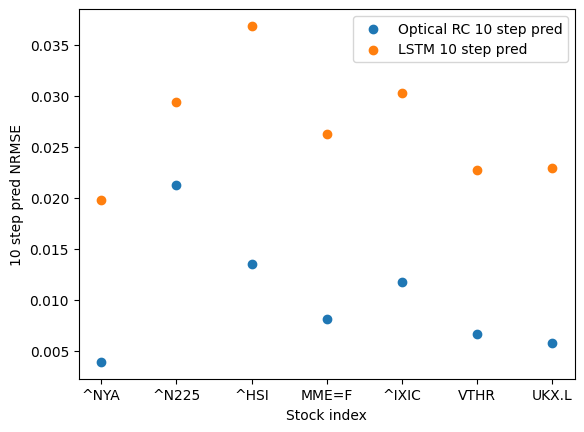

In [64]:
# plt.scatter(names,np.array(rc_10)/np.array(the_max),label="rc 10 scaled")
# plt.scatter(names,np.array(reg_10)/np.array(the_max),label="reg 10 scaled")
plt.scatter(names,np.array(rc_10),label='Optical RC 10 step pred')
plt.scatter(names,np.array(reg_10),label='LSTM 10 step pred')


# plt.scatter(names,np.abs(np.array(train_std)-np.array(test_std))/np.array(the_max),label="train - test")


# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend()

plt.xlabel("Stock index")
plt.ylabel("10 step pred NRMSE")
plt.savefig(f'{fig_path}/NRMSE_fig_10.png', dpi=600, bbox_inches='tight')

TypeError: text() missing 3 required positional arguments: 'x', 'y', and 's'

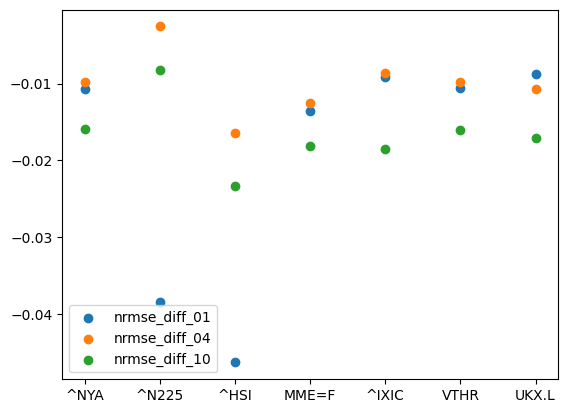

In [65]:
nrmse_diff_01 = np.subtract(rc_01, reg_01)
nrmse_diff_04 = np.subtract(rc_04, reg_04)
nrmse_diff_10 = np.subtract(rc_10, reg_10)

plt.scatter(names,np.array(nrmse_diff_01),label='nrmse_diff_01')
plt.scatter(names,np.array(nrmse_diff_04),label='nrmse_diff_04')
plt.scatter(names,np.array(nrmse_diff_10),label='nrmse_diff_10')
plt.legend()
plt.text(weight="bold")

plt.xlabel("Stock index")
plt.ylabel("NRMSE Difference")

#### Calculate the volatility of the stock datasets

In [66]:
reg

array([7914.13  , 7912.2   , 7891.1304, 7852.64  , 7831.58  , 7870.57  ,
       7773.03  , 7788.37  , 7702.64  , 7778.38  , 7764.0894, 7741.3296,
       7730.58  , 7754.6206, 7777.7007, 7751.08  , 7723.23  , 7742.3   ,
       7756.87  , 7770.99  , 7762.95  , 7627.1006, 7570.87  , 7627.2007,
       7522.07  , 7446.1396, 7490.2695, 7607.28  , 7599.99  , 7628.1   ,
       7624.34  , 7599.74  , 7562.36  , 7570.6895, 7594.7793, 7602.74  ,
       7628.26  , 7642.72  , 7569.31  , 7559.18  , 7502.03  , 7461.87  ,
       7453.58  , 7461.46  , 7500.49  , 7471.69  , 7531.5303, 7527.2603,
       7442.1   , 7280.5   , 7256.94  , 7273.7896, 7282.5195, 7416.11  ,
       7440.2104, 7434.57  , 7406.4194, 7453.6904, 7588.2   , 7646.0503,
       7663.7305, 7678.59  , 7691.8   , 7676.89  , 7692.7603, 7694.27  ,
       7699.41  , 7666.27  , 7561.63  , 7529.16  , 7564.37  , 7554.4897,
       7527.42  , 7587.3   , 7618.6   , 7524.16  , 7507.1504, 7389.6396,
       7356.88  , 7310.21  , 7262.43  , 7257.82  , 